In [1]:
import numpy as np
# import unet
import unet_gege
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
import h5py

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

# Load data

In [4]:
output_dir = 'saved_models/'
case_string = 'well_control_128x128'

In [5]:
data_dir = '/data/cees/gegewen/well_control_data/'

hf_r = h5py.File(data_dir + 'train_' + case_string + '_40000.hdf5', 'r')
# hf_r = h5py.File(data_dir + 'train_' + case_string + '_400.hdf5', 'r')
train_x = np.array(hf_r.get('k'))
train_y = np.array(hf_r.get('S'))
hf_r.close()

In [6]:
hf_w = h5py.File(data_dir + 'test_' + case_string + '_8000.hdf5', 'r')
# hf_w = h5py.File(data_dir + 'test_' + case_string + '_80.hdf5', 'r')
test_x = np.array(hf_w.get('k'))
test_y = np.array(hf_w.get('S'))
hf_w.close()

In [7]:
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (40000, 128, 128, 2)
train_y shape is  (40000, 128, 128, 1)
test_x shape is  (8000, 128, 128, 2)
test_y shape is  (8000, 128, 128, 1)


In [8]:
train_x = train_x[:20000, ...]
train_y = train_y[:20000, ...]
test_x = test_x[:100, ...]
test_y = test_y[:100, ...]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape ', test_x.shape)
print('test_y shape ', test_y.shape)

train_x shape is  (20000, 128, 128, 2)
train_y shape is  (20000, 128, 128, 1)
test_x shape  (100, 128, 128, 2)
test_y shape  (100, 128, 128, 1)


### Plot training dataset, train (Optional)

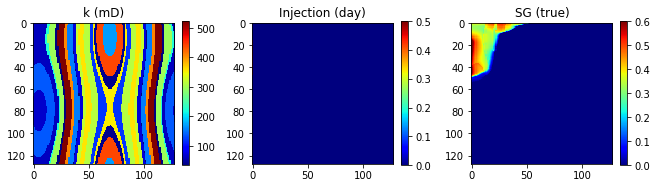

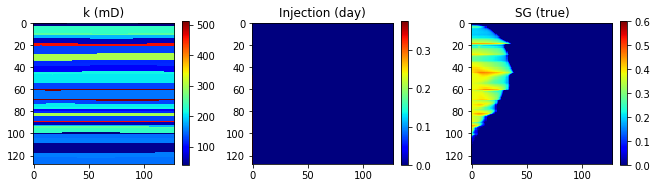

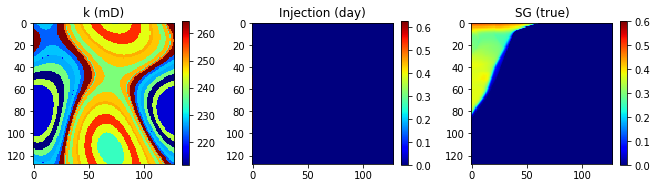

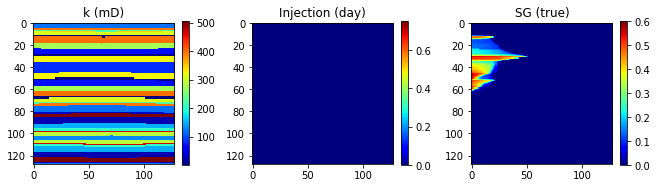

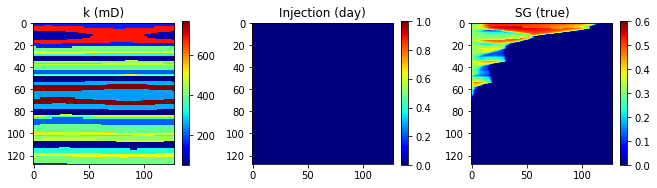

In [9]:
for k in range(5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = train_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()

### Plot test dataset, test (Optional)

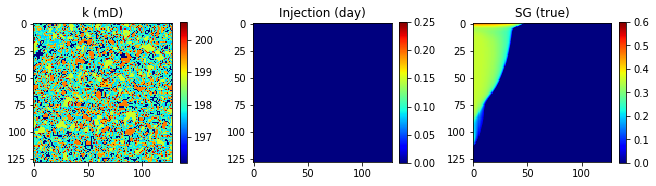

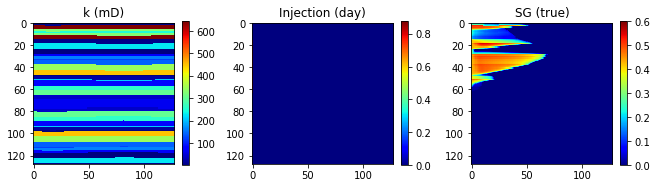

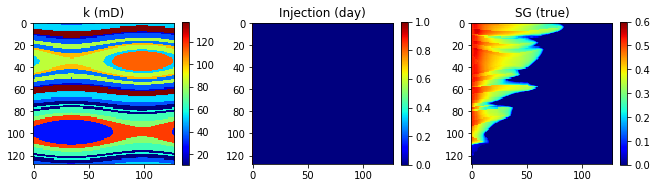

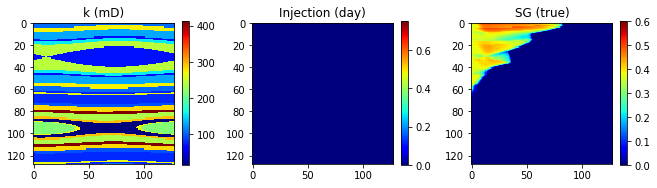

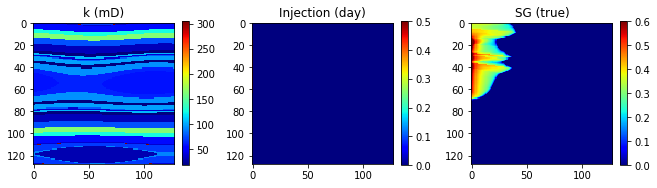

In [10]:
for k in range(5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = test_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    

    plt.tight_layout()
    plt.show()

# Training starts here
### Bypass this part if you only want test

In [21]:
# reload module, in case needed
# from importlib import reload
# reload(unet)

<module 'unet_2' from '/data/cees/zjin/cs231n/project/var-unet/unet_2.py'>

In [9]:
input_shape = (128, 128, 2)
output_shape = (128, 128, 1)

### Load the model of choice u-net

In [10]:
unet_model = unet_gege.create_vae(input_shape)
# unet_model.summary()

#### Train forward pass

In [11]:
# unet_up, hidden_shapes = unet.create_unet_up(input_shape)
# unet_down = unet.create_unet_down(hidden_shapes)
# #     unet_up.summary()
# #     unet_down.summary()

xc = Input(shape=input_shape) # perm + well location|
c = Input(shape=output_shape) # well location

# hidden_layers = unet_up(xc)
# x_hat = unet_down(hidden_layers)    
x_hat = unet_model(xc)

#### Define loss functions

In [12]:
def likelihood_loss(x, x_hat):
    '''
    Reconstruction loss, L2 norm
    '''
    v = 0.1
    return K.mean(K.sum((K.batch_flatten(x) - K.batch_flatten(x_hat)) ** 2 / (2*v), axis=-1))

def latent_kl_loss(q, p):
    mean1 = q
    mean2 = p
    
    kl = 0.5 * (mean2 - mean1)**2
    kl = K.sum(kl, axis = [1,2,3])
    kl = K.mean(kl)
    return kl

#### Compute loss

In [13]:
x = Input(shape=output_shape) # target saturation

likelihood_loss_value = likelihood_loss(x, x_hat)
# kl_loss = latent_kl_loss(z_posterior_mean, z_piror_mean)
# kl_weight = 5.0
# total_loss = likelihood_loss_value + kl_weight * kl_loss
total_loss = likelihood_loss_value


#### Build computation graph

In [14]:
epoch = 150
learning_rate = 5e-4
train_nr = train_x.shape[0]
test_nr = test_x.shape[0]
batch_size = 16
num_batch = int(train_nr/batch_size) 

In [15]:
opt = Adam(lr=learning_rate)

# trainable_weights = unet_up.trainable_weights + unet_down.trainable_weights
trainable_weights = unet_model.trainable_weights

updates = opt.get_updates(total_loss, trainable_weights)

iterate = K.function([xc, c, x], [total_loss], updates=updates)

eval_loss = K.function([xc, c, x], [total_loss])


#### Start training

In [ ]:
train_loss_record = []
test_loss_record =[]

for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        x_batch = train_x[ind0:ind0+batch_size, ...]
        y_batch = train_y[ind0:ind0+batch_size, ...]
        
        train_losses = iterate([x_batch, x_batch[:,:,:,[1]], y_batch])
        if ib % 50 == 0:
            print('Epoch %d/%d, Batch %d/%d, Total Loss %f' %(e+1, epoch, ib+1, num_batch, train_losses[0]))
        
        eval_losses = eval_loss([test_x, test_x[:,:,:,[1]], test_y])
    train_loss_record.append(train_losses[0])
    test_loss_record.append(eval_losses[0])

    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train Total Loss %f, Eval Total Loss %f' % (e + 1, epoch, train_losses[0], eval_losses[0]))
    print('\n')
    print('====================================================')
# unet_up.save_weights(output_dir + 'unet_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
# unet_down.save_weights(output_dir + 'unet_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
unet_model.save_weights(output_dir + 'unet_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

Epoch 1/150, Batch 1/1250, Total Loss 1087.951660
Epoch 1/150, Batch 51/1250, Total Loss 587.038696
Epoch 1/150, Batch 101/1250, Total Loss 469.838745
Epoch 1/150, Batch 151/1250, Total Loss 343.186676
Epoch 1/150, Batch 201/1250, Total Loss 212.986176
Epoch 1/150, Batch 251/1250, Total Loss 144.132965
Epoch 1/150, Batch 301/1250, Total Loss 128.866776
Epoch 1/150, Batch 351/1250, Total Loss 128.038208
Epoch 1/150, Batch 401/1250, Total Loss 117.616463
Epoch 1/150, Batch 451/1250, Total Loss 152.767990
Epoch 1/150, Batch 501/1250, Total Loss 100.506256
Epoch 1/150, Batch 551/1250, Total Loss 138.573746
Epoch 1/150, Batch 601/1250, Total Loss 89.421188
Epoch 1/150, Batch 651/1250, Total Loss 93.407928
Epoch 1/150, Batch 701/1250, Total Loss 80.213043
Epoch 1/150, Batch 751/1250, Total Loss 100.854301
Epoch 1/150, Batch 801/1250, Total Loss 62.628567
Epoch 1/150, Batch 851/1250, Total Loss 83.723465
Epoch 1/150, Batch 901/1250, Total Loss 59.714470
Epoch 1/150, Batch 951/1250, Total Loss

Epoch 6/150, Batch 1051/1250, Total Loss 24.336983
Epoch 6/150, Batch 1101/1250, Total Loss 16.821291
Epoch 6/150, Batch 1151/1250, Total Loss 26.298489
Epoch 6/150, Batch 1201/1250, Total Loss 19.523367


Epoch 6/150, Train Total Loss 30.529179, Eval Total Loss 31.522263


Epoch 7/150, Batch 1/1250, Total Loss 29.368038
Epoch 7/150, Batch 51/1250, Total Loss 21.393230
Epoch 7/150, Batch 101/1250, Total Loss 20.411728
Epoch 7/150, Batch 151/1250, Total Loss 19.460945
Epoch 7/150, Batch 201/1250, Total Loss 17.165977
Epoch 7/150, Batch 251/1250, Total Loss 24.209267
Epoch 7/150, Batch 301/1250, Total Loss 15.045370
Epoch 7/150, Batch 351/1250, Total Loss 29.709213
Epoch 7/150, Batch 401/1250, Total Loss 20.256565
Epoch 7/150, Batch 451/1250, Total Loss 22.576099
Epoch 7/150, Batch 501/1250, Total Loss 17.033907
Epoch 7/150, Batch 551/1250, Total Loss 29.454063
Epoch 7/150, Batch 601/1250, Total Loss 32.375935
Epoch 7/150, Batch 651/1250, Total Loss 14.945524
Epoch 7/150, Batch 701/1250,

Epoch 12/150, Batch 651/1250, Total Loss 16.143013
Epoch 12/150, Batch 701/1250, Total Loss 13.372080
Epoch 12/150, Batch 751/1250, Total Loss 13.034294
Epoch 12/150, Batch 801/1250, Total Loss 11.429811
Epoch 12/150, Batch 851/1250, Total Loss 17.828350
Epoch 12/150, Batch 901/1250, Total Loss 15.559227
Epoch 12/150, Batch 951/1250, Total Loss 16.095856
Epoch 12/150, Batch 1001/1250, Total Loss 16.863422
Epoch 12/150, Batch 1051/1250, Total Loss 16.166458
Epoch 12/150, Batch 1101/1250, Total Loss 24.056870
Epoch 12/150, Batch 1151/1250, Total Loss 10.152302
Epoch 12/150, Batch 1201/1250, Total Loss 18.506145


Epoch 12/150, Train Total Loss 16.448233, Eval Total Loss 16.948359


Epoch 13/150, Batch 1/1250, Total Loss 15.126569
Epoch 13/150, Batch 51/1250, Total Loss 15.826654
Epoch 13/150, Batch 101/1250, Total Loss 16.118374
Epoch 13/150, Batch 151/1250, Total Loss 13.874891
Epoch 13/150, Batch 201/1250, Total Loss 11.078051
Epoch 13/150, Batch 251/1250, Total Loss 13.965222
Epoch 13

Epoch 18/150, Batch 151/1250, Total Loss 11.473669
Epoch 18/150, Batch 201/1250, Total Loss 9.953897
Epoch 18/150, Batch 251/1250, Total Loss 10.012882
Epoch 18/150, Batch 301/1250, Total Loss 8.186861
Epoch 18/150, Batch 351/1250, Total Loss 9.317741
Epoch 18/150, Batch 401/1250, Total Loss 13.480665
Epoch 18/150, Batch 451/1250, Total Loss 12.117498
Epoch 18/150, Batch 501/1250, Total Loss 8.652778
Epoch 18/150, Batch 551/1250, Total Loss 20.019760
Epoch 18/150, Batch 601/1250, Total Loss 8.638882
Epoch 18/150, Batch 651/1250, Total Loss 9.487658
Epoch 18/150, Batch 701/1250, Total Loss 9.760326
Epoch 18/150, Batch 751/1250, Total Loss 14.432477
Epoch 18/150, Batch 801/1250, Total Loss 10.809858
Epoch 18/150, Batch 851/1250, Total Loss 10.690134
Epoch 18/150, Batch 901/1250, Total Loss 19.136665
Epoch 18/150, Batch 951/1250, Total Loss 21.058805
Epoch 18/150, Batch 1001/1250, Total Loss 15.626450
Epoch 18/150, Batch 1051/1250, Total Loss 13.651433
Epoch 18/150, Batch 1101/1250, Total

Epoch 23/150, Batch 1151/1250, Total Loss 7.361808
Epoch 23/150, Batch 1201/1250, Total Loss 6.977328


Epoch 23/150, Train Total Loss 12.635828, Eval Total Loss 9.630678


Epoch 24/150, Batch 1/1250, Total Loss 7.305388
Epoch 24/150, Batch 51/1250, Total Loss 9.124329
Epoch 24/150, Batch 101/1250, Total Loss 6.934216
Epoch 24/150, Batch 151/1250, Total Loss 7.989895
Epoch 24/150, Batch 201/1250, Total Loss 7.156258
Epoch 24/150, Batch 251/1250, Total Loss 11.418707
Epoch 24/150, Batch 301/1250, Total Loss 11.173479
Epoch 24/150, Batch 351/1250, Total Loss 8.199394
Epoch 24/150, Batch 401/1250, Total Loss 12.215576
Epoch 24/150, Batch 451/1250, Total Loss 8.589554
Epoch 24/150, Batch 501/1250, Total Loss 12.358688
Epoch 24/150, Batch 551/1250, Total Loss 13.836643
Epoch 24/150, Batch 601/1250, Total Loss 11.891870
Epoch 24/150, Batch 651/1250, Total Loss 7.310124
Epoch 24/150, Batch 701/1250, Total Loss 7.576226
Epoch 24/150, Batch 751/1250, Total Loss 8.283493
Epoch 24/150, Batch 801/

Epoch 29/150, Batch 751/1250, Total Loss 7.924266
Epoch 29/150, Batch 801/1250, Total Loss 6.724490
Epoch 29/150, Batch 851/1250, Total Loss 7.530182
Epoch 29/150, Batch 901/1250, Total Loss 12.451626
Epoch 29/150, Batch 951/1250, Total Loss 9.676056
Epoch 29/150, Batch 1001/1250, Total Loss 8.528666
Epoch 29/150, Batch 1051/1250, Total Loss 10.007580
Epoch 29/150, Batch 1101/1250, Total Loss 7.500990
Epoch 29/150, Batch 1151/1250, Total Loss 6.866974
Epoch 29/150, Batch 1201/1250, Total Loss 8.652539


Epoch 29/150, Train Total Loss 7.255088, Eval Total Loss 9.236627


Epoch 30/150, Batch 1/1250, Total Loss 7.613383
Epoch 30/150, Batch 51/1250, Total Loss 8.245499
Epoch 30/150, Batch 101/1250, Total Loss 7.043787
Epoch 30/150, Batch 151/1250, Total Loss 6.930881
Epoch 30/150, Batch 201/1250, Total Loss 7.515429
Epoch 30/150, Batch 251/1250, Total Loss 9.343834
Epoch 30/150, Batch 301/1250, Total Loss 6.319495
Epoch 30/150, Batch 351/1250, Total Loss 7.944781
Epoch 30/150, Batch 401/12

Epoch 35/150, Batch 401/1250, Total Loss 8.216345
Epoch 35/150, Batch 451/1250, Total Loss 5.605032
Epoch 35/150, Batch 501/1250, Total Loss 5.660729
Epoch 35/150, Batch 551/1250, Total Loss 9.290434
Epoch 35/150, Batch 601/1250, Total Loss 10.024374
Epoch 35/150, Batch 651/1250, Total Loss 8.099328
Epoch 35/150, Batch 701/1250, Total Loss 12.324848
Epoch 35/150, Batch 751/1250, Total Loss 6.452028
Epoch 35/150, Batch 801/1250, Total Loss 8.300182
Epoch 35/150, Batch 851/1250, Total Loss 6.880382
Epoch 35/150, Batch 901/1250, Total Loss 9.876327
Epoch 35/150, Batch 951/1250, Total Loss 7.784695
Epoch 35/150, Batch 1001/1250, Total Loss 7.842652
Epoch 35/150, Batch 1051/1250, Total Loss 8.826000
Epoch 35/150, Batch 1101/1250, Total Loss 5.553408
Epoch 35/150, Batch 1151/1250, Total Loss 4.950888
Epoch 35/150, Batch 1201/1250, Total Loss 5.558025


Epoch 35/150, Train Total Loss 4.979497, Eval Total Loss 6.214300


Epoch 36/150, Batch 1/1250, Total Loss 5.380028
Epoch 36/150, Batch 51/12

Epoch 41/150, Batch 51/1250, Total Loss 9.836357
Epoch 41/150, Batch 101/1250, Total Loss 4.619716
Epoch 41/150, Batch 151/1250, Total Loss 5.916543
Epoch 41/150, Batch 201/1250, Total Loss 6.301519
Epoch 41/150, Batch 251/1250, Total Loss 5.019289
Epoch 41/150, Batch 301/1250, Total Loss 4.096500
Epoch 41/150, Batch 351/1250, Total Loss 4.954750
Epoch 41/150, Batch 401/1250, Total Loss 6.434319
Epoch 41/150, Batch 451/1250, Total Loss 7.490320
Epoch 41/150, Batch 501/1250, Total Loss 4.900835
Epoch 41/150, Batch 551/1250, Total Loss 9.149382
Epoch 41/150, Batch 601/1250, Total Loss 16.022228
Epoch 41/150, Batch 651/1250, Total Loss 8.637627
Epoch 41/150, Batch 701/1250, Total Loss 6.773402
Epoch 41/150, Batch 751/1250, Total Loss 5.496849
Epoch 41/150, Batch 801/1250, Total Loss 4.925707
Epoch 41/150, Batch 851/1250, Total Loss 4.641971
Epoch 41/150, Batch 901/1250, Total Loss 7.287947
Epoch 41/150, Batch 951/1250, Total Loss 7.046837
Epoch 41/150, Batch 1001/1250, Total Loss 4.400261

Epoch 46/150, Batch 1101/1250, Total Loss 4.388357
Epoch 46/150, Batch 1151/1250, Total Loss 4.253662
Epoch 46/150, Batch 1201/1250, Total Loss 7.140965


Epoch 46/150, Train Total Loss 5.629869, Eval Total Loss 6.376446


Epoch 47/150, Batch 1/1250, Total Loss 5.216569
Epoch 47/150, Batch 51/1250, Total Loss 8.450836
Epoch 47/150, Batch 101/1250, Total Loss 4.818969
Epoch 47/150, Batch 151/1250, Total Loss 5.351581
Epoch 47/150, Batch 201/1250, Total Loss 4.490648
Epoch 47/150, Batch 251/1250, Total Loss 4.753063
Epoch 47/150, Batch 301/1250, Total Loss 3.436936
Epoch 47/150, Batch 351/1250, Total Loss 4.817208
Epoch 47/150, Batch 401/1250, Total Loss 6.369651
Epoch 47/150, Batch 451/1250, Total Loss 8.325627
Epoch 47/150, Batch 501/1250, Total Loss 5.118612
Epoch 47/150, Batch 551/1250, Total Loss 9.613637
Epoch 47/150, Batch 601/1250, Total Loss 4.551346
Epoch 47/150, Batch 651/1250, Total Loss 6.089767
Epoch 47/150, Batch 701/1250, Total Loss 8.851368
Epoch 47/150, Batch 751/1250, 

Epoch 52/150, Batch 751/1250, Total Loss 4.541272
Epoch 52/150, Batch 801/1250, Total Loss 3.454617
Epoch 52/150, Batch 851/1250, Total Loss 4.163702
Epoch 52/150, Batch 901/1250, Total Loss 4.391172
Epoch 52/150, Batch 951/1250, Total Loss 4.457020
Epoch 52/150, Batch 1001/1250, Total Loss 2.968116
Epoch 52/150, Batch 1051/1250, Total Loss 3.723228
Epoch 52/150, Batch 1101/1250, Total Loss 3.492535
Epoch 52/150, Batch 1151/1250, Total Loss 3.077313
Epoch 52/150, Batch 1201/1250, Total Loss 4.419910


Epoch 52/150, Train Total Loss 4.101367, Eval Total Loss 5.505390


Epoch 53/150, Batch 1/1250, Total Loss 3.260900
Epoch 53/150, Batch 51/1250, Total Loss 4.555189
Epoch 53/150, Batch 101/1250, Total Loss 4.066044
Epoch 53/150, Batch 151/1250, Total Loss 3.656336
Epoch 53/150, Batch 201/1250, Total Loss 4.008288
Epoch 53/150, Batch 251/1250, Total Loss 5.356734
Epoch 53/150, Batch 301/1250, Total Loss 3.570906
Epoch 53/150, Batch 351/1250, Total Loss 4.527261
Epoch 53/150, Batch 401/1250

Epoch 58/150, Batch 401/1250, Total Loss 5.398105
Epoch 58/150, Batch 451/1250, Total Loss 4.141839
Epoch 58/150, Batch 501/1250, Total Loss 3.491283
Epoch 58/150, Batch 551/1250, Total Loss 6.275644
Epoch 58/150, Batch 601/1250, Total Loss 4.398809
Epoch 58/150, Batch 651/1250, Total Loss 3.936941
Epoch 58/150, Batch 701/1250, Total Loss 3.043855
Epoch 58/150, Batch 751/1250, Total Loss 3.628377
Epoch 58/150, Batch 801/1250, Total Loss 3.715263
Epoch 58/150, Batch 851/1250, Total Loss 4.263480
Epoch 58/150, Batch 901/1250, Total Loss 3.888489
Epoch 58/150, Batch 951/1250, Total Loss 4.404821
Epoch 58/150, Batch 1001/1250, Total Loss 3.346243
Epoch 58/150, Batch 1051/1250, Total Loss 3.570129
Epoch 58/150, Batch 1101/1250, Total Loss 2.815203
Epoch 58/150, Batch 1151/1250, Total Loss 3.315711
Epoch 58/150, Batch 1201/1250, Total Loss 5.002966


Epoch 58/150, Train Total Loss 4.569166, Eval Total Loss 6.235866


Epoch 59/150, Batch 1/1250, Total Loss 4.331844
Epoch 59/150, Batch 51/1250

Epoch 64/150, Batch 51/1250, Total Loss 4.811964
Epoch 64/150, Batch 101/1250, Total Loss 3.652171
Epoch 64/150, Batch 151/1250, Total Loss 4.572692
Epoch 64/150, Batch 201/1250, Total Loss 3.098453
Epoch 64/150, Batch 251/1250, Total Loss 3.345343
Epoch 64/150, Batch 301/1250, Total Loss 3.063843
Epoch 64/150, Batch 351/1250, Total Loss 3.305186
Epoch 64/150, Batch 401/1250, Total Loss 4.511242
Epoch 64/150, Batch 451/1250, Total Loss 4.238020
Epoch 64/150, Batch 501/1250, Total Loss 3.162165
Epoch 64/150, Batch 551/1250, Total Loss 6.294941
Epoch 64/150, Batch 601/1250, Total Loss 3.263901
Epoch 64/150, Batch 651/1250, Total Loss 4.088661
Epoch 64/150, Batch 701/1250, Total Loss 4.661395
Epoch 64/150, Batch 751/1250, Total Loss 3.410591
Epoch 64/150, Batch 801/1250, Total Loss 3.921069
Epoch 64/150, Batch 851/1250, Total Loss 3.727259
Epoch 64/150, Batch 901/1250, Total Loss 3.187942
Epoch 64/150, Batch 951/1250, Total Loss 4.676950
Epoch 64/150, Batch 1001/1250, Total Loss 3.549546


Epoch 69/150, Batch 1151/1250, Total Loss 3.679604
Epoch 69/150, Batch 1201/1250, Total Loss 5.579304


Epoch 69/150, Train Total Loss 3.646810, Eval Total Loss 5.524205


Epoch 70/150, Batch 1/1250, Total Loss 3.719994
Epoch 70/150, Batch 51/1250, Total Loss 4.268773
Epoch 70/150, Batch 101/1250, Total Loss 3.900487
Epoch 70/150, Batch 151/1250, Total Loss 2.829715
Epoch 70/150, Batch 201/1250, Total Loss 3.463471
Epoch 70/150, Batch 251/1250, Total Loss 3.752616
Epoch 70/150, Batch 301/1250, Total Loss 2.828559
Epoch 70/150, Batch 351/1250, Total Loss 3.858010
Epoch 70/150, Batch 401/1250, Total Loss 5.788060
Epoch 70/150, Batch 451/1250, Total Loss 6.280436
Epoch 70/150, Batch 501/1250, Total Loss 3.047198
Epoch 70/150, Batch 551/1250, Total Loss 6.595269
Epoch 70/150, Batch 601/1250, Total Loss 4.609085
Epoch 70/150, Batch 651/1250, Total Loss 4.228621
Epoch 70/150, Batch 701/1250, Total Loss 5.189772
Epoch 70/150, Batch 751/1250, Total Loss 4.083488
Epoch 70/150, Batch 801/1250, T

Epoch 75/150, Batch 801/1250, Total Loss 3.602897
Epoch 75/150, Batch 851/1250, Total Loss 5.842038
Epoch 75/150, Batch 901/1250, Total Loss 5.950854
Epoch 75/150, Batch 951/1250, Total Loss 4.991915
Epoch 75/150, Batch 1001/1250, Total Loss 3.525806
Epoch 75/150, Batch 1051/1250, Total Loss 3.961120
Epoch 75/150, Batch 1101/1250, Total Loss 2.990951
Epoch 75/150, Batch 1151/1250, Total Loss 2.970659
Epoch 75/150, Batch 1201/1250, Total Loss 4.006555


Epoch 75/150, Train Total Loss 4.982035, Eval Total Loss 8.226507


Epoch 76/150, Batch 1/1250, Total Loss 4.796749
Epoch 76/150, Batch 51/1250, Total Loss 4.260745
Epoch 76/150, Batch 101/1250, Total Loss 3.794948
Epoch 76/150, Batch 151/1250, Total Loss 3.916067
Epoch 76/150, Batch 201/1250, Total Loss 2.885340
Epoch 76/150, Batch 251/1250, Total Loss 7.574884
Epoch 76/150, Batch 301/1250, Total Loss 4.317028
Epoch 76/150, Batch 351/1250, Total Loss 3.289481
Epoch 76/150, Batch 401/1250, Total Loss 4.751269
Epoch 76/150, Batch 451/1250

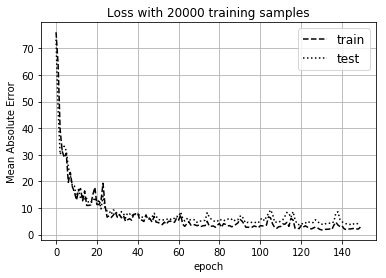

In [17]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(range(epoch), train_loss_record,  'k--', label='train')
ax.plot(range(epoch), test_loss_record,  'k:', label='test')


legend = ax.legend(loc='upper right', fontsize='large')

ax.set(xlabel='epoch', ylabel='Mean Absolute Error',
        title='Loss with %d training samples' % (train_x.shape[0]))
ax.grid()

fig.savefig("figs/loss_%dtrain.png"%(train_x.shape[0]))
plt.show()

# Test starts here


#### If you have pre-trained model saved,
#### no need to run training section.
#### Just load the data and start from here

In [18]:
epoch = 150
learning_rate = 5e-4
train_nr = train_x.shape[0]
test_nr = test_x.shape[0]

input_shape = (128,128,2)
output_shape = (128,128,1)

# unet_up, hidden_shapes = unet.create_unet_up(input_shape)
# unet_down = unet.create_unet_down(hidden_shapes)
a_unet = unet_gege.create_vae(input_shape)

# unet_up.load_weights(output_dir + 'unet_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
# unet_down.load_weights(output_dir + 'unet_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
a_unet.load_weights(output_dir + 'unet_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

#### Transfer forward pass (the only test task we care about)

In [19]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=(128,128,1)) # well location

# hidden_layers = unet_up(xc)
# x_hat = unet_down(hidden_layers)
x_hat = a_unet(xc)

unet_model = Model([xc, c], [x_hat])

In [20]:
# predict test set
sat_pred_eval = unet_model.predict([test_x, test_x[:,:,:,[1]]])
sat_pred_eval.shape

(100, 128, 128, 1)

In [21]:
# predict training set
sat_pred_train = unet_model.predict([train_x[:10,...], train_x[:10,:,:,[1]]])
sat_pred_train.shape

(10, 128, 128, 1)

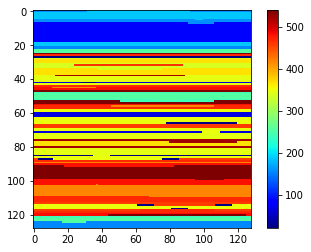

In [22]:
num_test = 7
k_fig = plt.figure()
plt.imshow(test_x[num_test,:,:,0]*1000)
plt.colorbar(fraction=0.046)

In [23]:
# num_test = 7

# for i in range(16):
#     fig = plt.figure(figsize=(15,3))
#     plt.set_cmap('gray')
    
#     plt.subplot(1,3,1)
#     plt.imshow(vae_weights[0][:,:,0,i])
#     plt.colorbar(fraction=0.046)
# #     plt.clim([-0.1, 0.1])

#     plt.subplot(1,3,2)
#     plt.imshow(vae_weights[0][:,:,1,i])
#     plt.colorbar(fraction=0.046)
# #     plt.clim([-0.1, 0.1])

#     plt.subplot(1,3,3)
# #     plt.set_cmap('jet')
#     plt.imshow(sat_pred_eval[0][num_test,:,:,i])
#     plt.colorbar(fraction=0.046)
# #     fig.savefig('layer1'+'channel'+str(i)+'.png')


In [24]:
# plt.set_cmap('jet')
# # k_fig = plt.figure()
# # plt.imshow(test_x[0,:,:,0])
# # plt.colorbar(fraction=0.046)
# # k_fig.savefig('k.png')
# layer = 11
# for i in range(32):
#     fig = plt.figure()
#     plt.imshow(sat_pred_eval[layer-1][0,:,:,i])
#     plt.colorbar(fraction=0.046)
#     fig.savefig('figs/layer'+str(layer)+'channel'+str(i)+'.png')


In [25]:
# epoch_plot = np.asarray(epoch_plot_list)+1
# rec_loss = np.asarray(rec_loss_list)/16384/16
# eval_loss = np.asarray(eval_loss_list)/16384/16
# rec_loss = np.sqrt(rec_loss)
# eval_loss = np.sqrt(eval_loss)
# print(epoch_plot)
# print(rec_loss)
# print(eval_loss)

In [26]:
# # Data for plotting
# fig, ax = plt.subplots()
# ax.plot(epoch_plot, rec_loss,  'k--', label='train')
# ax.plot(epoch_plot, eval_loss,  'k:', label='test')


# legend = ax.legend(loc='upper right', fontsize='large')

# ax.set(xlabel='epoch', ylabel='Mean Absolute Error',
#         title='20,000 Training Samples')
# ax.grid()

# fig.savefig("test.png")
# plt.show()

In [24]:
train_inj_plot = train_x * 200
train_inj_plot[:, :, 1 ,1] = train_inj_plot[:, :, 0, 1]
train_inj_plot[:, :, 2 ,1] = train_inj_plot[:, :, 0, 1]
test_inj_plot = test_x * 200
test_inj_plot[:, :, 1 ,1] = test_inj_plot[:, :, 0, 1]
test_inj_plot[:, :, 2 ,1] = test_inj_plot[:, :, 0, 1]

## Training set simulation results

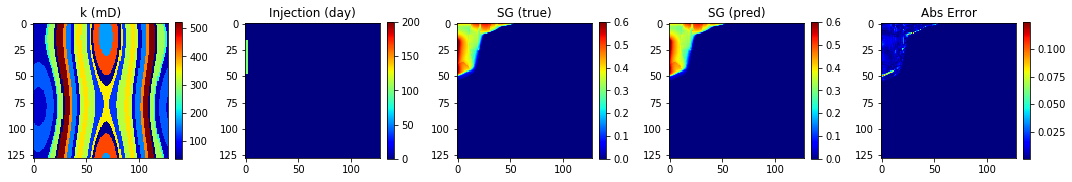

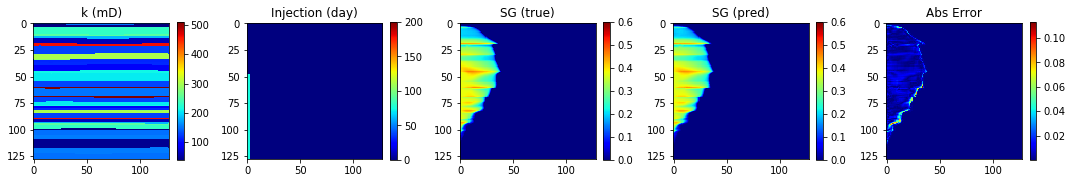

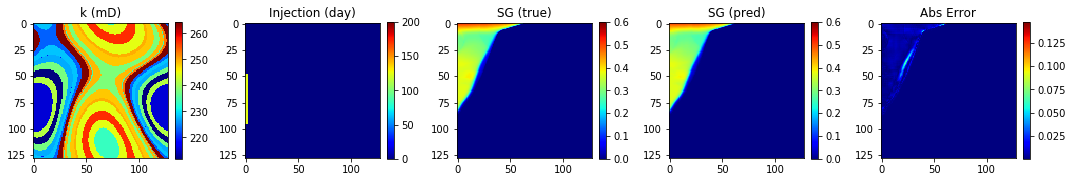

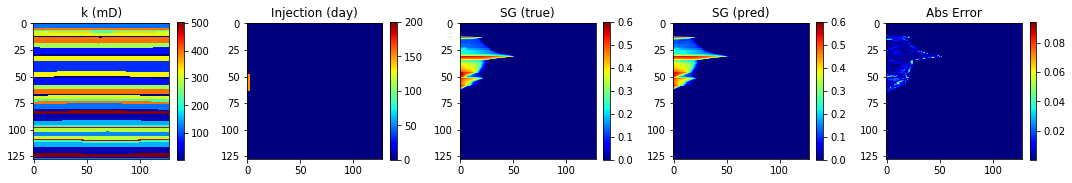

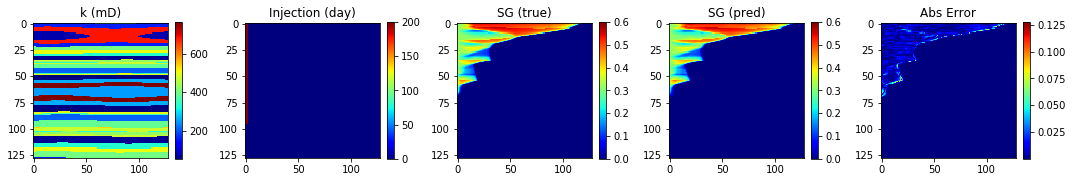

In [25]:
for k in range(0,5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plt.imshow(train_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,4)
    plt.imshow(sat_pred_train[k, :, :, 0].reshape(128, 128))
    plt.title('SG (pred)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,5)
    rel_err = np.abs((sat_pred_train[k, :, :, 0] - train_y[k, :, :, 0]))
    plt.imshow(rel_err) 
    plt.title('Abs. error')
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
    plt.show()


## Test simulation results

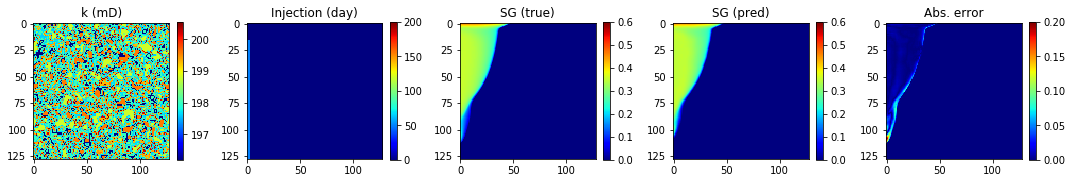

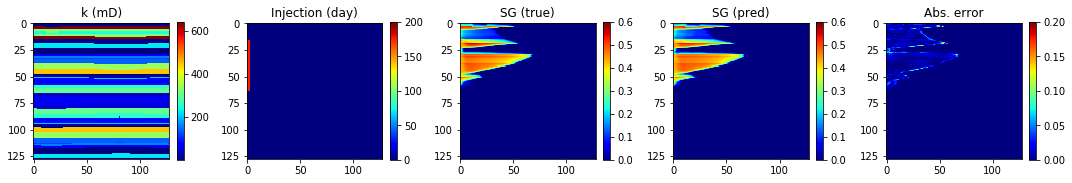

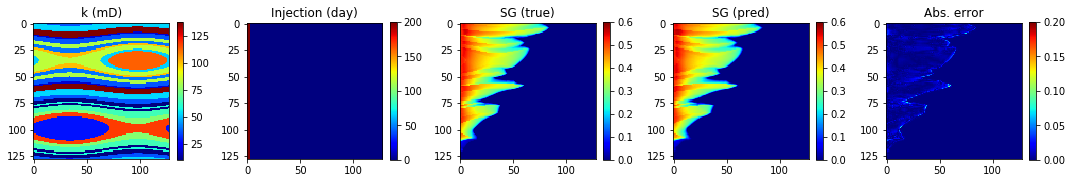

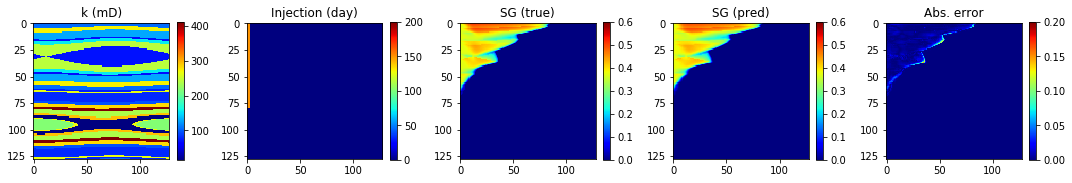

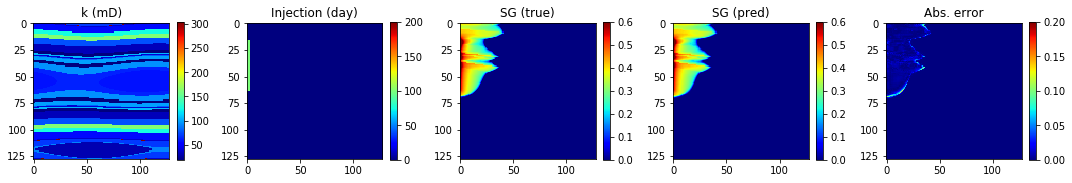

In [27]:
for k in range(0,5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plt.imshow(test_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('SG (true)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,4)
    plt.imshow(sat_pred_eval[k, :, :, 0].reshape(128, 128))
    plt.title('SG (pred)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,5)
    abs_err = np.abs((sat_pred_eval[k, :, :, 0] - test_y[k, :, :, 0]))
    plt.imshow(abs_err) 
    plt.title('Abs. error')
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
    plt.tight_layout()
    plt.show()

    